In [1]:
import pandas as pd

train_transaction = pd.read_csv(f"datasets/train_transaction.csv")
test_transaction  = pd.read_csv(f"datasets/test_transaction.csv")

print(train_transaction.shape) #590540 row dan 393 feature + 1 target
print(test_transaction.shape) #506691 row dan 393 feature

(590540, 394)
(506691, 393)


In [2]:
train_transaction.head() #isFraud adalah target featurenya

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_transaction.head() #uji data baru, setelah pembuatan model machine learningnya

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_transaction.shape

(590540, 394)

In [5]:
test_transaction.shape

(506691, 393)

In [6]:
train_transaction.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

In [7]:
# ====================================================
# 1. Import Libraries & Cek Kompatibilitas GPU
# ====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve, precision_recall_curve,
                             average_precision_score)
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["XGBOOST_GPU_ALLOCATOR"] = "cuda_malloc_async"

print(xgb.build_info(), "\n")   # harus ada 'USE_CUDA': True


# Check GPU availability
print("XGBoost Version:", xgb.__version__)
try:
    # Test GPU
    test_params = {'tree_method': 'gpu_hist', 'device': 'cuda'}
    GPU_AVAILABLE = True
    print("✅ GPU is available! Using cuda")
except:
    GPU_AVAILABLE = False
    print("❌ GPU not available. Using CPU (hist)")

print(f"\nTrain shape: {train_transaction.shape}")
print(f"Test shape: {test_transaction.shape}")

{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 5], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 6, 1], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_NVCOMP': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'C:\\Users\\HP\\AppData\\Roaming\\Python\\Python312\\site-packages\\xgboost\\lib\\xgboost.dll'} 

XGBoost Version: 3.1.2
✅ GPU is available! Using cuda

Train shape: (590540, 394)
Test shape: (506691, 393)


TARGET DISTRIBUTION (isFraud)
Non-Fraud (0): 569,877 (96.50%)
Fraud (1): 20,663 (3.50%)

Imbalance Ratio: 1:27


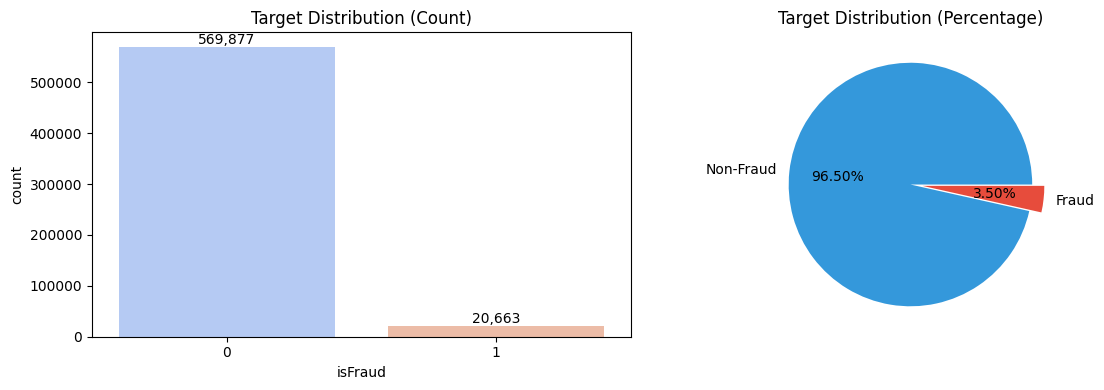

In [8]:
# ====================================================
# 2. Exploratory Data Analysis (EDA)
# ====================================================

# Check target distribution (Fraud vs Non-Fraud)
print("=" * 50)
print("TARGET DISTRIBUTION (isFraud)")
print("=" * 50)
target_counts = train_transaction['isFraud'].value_counts()
target_pct = train_transaction['isFraud'].value_counts(normalize=True) * 100
print(f"Non-Fraud (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"Fraud (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{target_counts[0]//target_counts[1]}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
sns.countplot(x='isFraud', data=train_transaction, ax=axes[0], palette='coolwarm')
axes[0].set_title('Target Distribution (Count)')
axes[0].set_xlabel('isFraud')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

# Pie chart
axes[1].pie(target_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', 
            colors=['#3498db', '#e74c3c'], explode=[0, 0.1])
axes[1].set_title('Target Distribution (Percentage)')

plt.tight_layout()
plt.show()

In [9]:
# ====================================================
# 3. Data Preprocessing
# ====================================================

# Separate features and target
X = train_transaction.drop(['isFraud', 'TransactionID'], axis=1)
y = train_transaction['isFraud']
X_test_final = test_transaction.drop(['TransactionID'], axis=1)
test_ids = test_transaction['TransactionID']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test_final.shape}")

# Identify column types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Categorical columns: {categorical_cols}")

Features shape: (590540, 392)
Target shape: (590540,)
Test features shape: (506691, 392)

Numerical columns: 378
Categorical columns: 14
Categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [10]:
# ====================================================
# 4. Handle Missing Values & Encode Categoricals
# ====================================================

# Check missing values percentage
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
print("Top 20 columns with highest missing values (%):")
print(missing_pct.head(20))

# Drop columns with >90% missing values
high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
print(f"\nDropping {len(high_missing_cols)} columns with >90% missing values")

X = X.drop(columns=high_missing_cols)
X_test_final = X_test_final.drop(columns=high_missing_cols)

print(f"New features shape: {X.shape}")

Top 20 columns with highest missing values (%):
dist2    93.628374
D7       93.409930
D13      89.509263
D14      89.469469
D12      89.041047
D6       87.606767
D8       87.312290
D9       87.312290
V148     86.123717
V147     86.123717
V141     86.123717
V140     86.123717
V153     86.123717
V158     86.123717
V163     86.123717
V155     86.123717
V157     86.123717
V161     86.123717
V142     86.123717
V138     86.123717
dtype: float64

Dropping 2 columns with >90% missing values
New features shape: (590540, 390)


In [11]:
# ====================================================
# 5. Label Encoding for Categorical Columns
# ====================================================

# Update categorical columns list after dropping
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

# Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Combine train and test for consistent encoding
    combined = pd.concat([X[col].astype(str), X_test_final[col].astype(str)])
    le.fit(combined)
    
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))
    label_encoders[col] = le
    
print(f"\n✅ Encoded {len(categorical_cols)} categorical columns")
print(f"Final X shape: {X.shape}")
print(f"Final X_test shape: {X_test_final.shape}")

Categorical columns to encode: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

✅ Encoded 14 categorical columns
Final X shape: (590540, 390)
Final X_test shape: (506691, 390)


In [12]:
# ====================================================
# 6. Fill Remaining Missing Values
# ====================================================

# Fill numerical missing values with median
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        X_test_final[col] = X_test_final[col].fillna(median_val)

print(f"Missing values in X after filling: {X.isnull().sum().sum()}")
print(f"Missing values in X_test after filling: {X_test_final.isnull().sum().sum()}")

Missing values in X after filling: 0
Missing values in X_test after filling: 4787


In [13]:
# ====================================================
# 7. Train-Validation Split
# ====================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Stratified split to maintain class distribution
)

print("Train-Validation Split:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\ny_val distribution:\n{y_val.value_counts(normalize=True)}")

Train-Validation Split:
X_train: (472432, 390)
X_val: (118108, 390)
y_train distribution:
isFraud
0    0.965011
1    0.034989
Name: proportion, dtype: float64

y_val distribution:
isFraud
0    0.965007
1    0.034993
Name: proportion, dtype: float64


In [14]:
# ====================================================
# 8. Baseline XGBoost Model
# ====================================================

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

baseline_params = {
    'n_estimators': 150,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'eval_metric': 'auc',

    # GPU engine
    'tree_method': 'hist',
    'device': 'cuda',
    'predictor': 'gpu_predictor',

    # VRAM safe
    'max_bin': 256
}

baseline_model = XGBClassifier(**baseline_params)
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

y_val_pred_proba = baseline_model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"\n🚀 Baseline GPU ROC-AUC: {baseline_auc:.4f}")


Scale pos weight: 27.58
[0]	validation_0-auc:0.84319	validation_1-auc:0.84068
[50]	validation_0-auc:0.91821	validation_1-auc:0.90868
[100]	validation_0-auc:0.93982	validation_1-auc:0.92576
[149]	validation_0-auc:0.95447	validation_1-auc:0.93664

🚀 Baseline GPU ROC-AUC: 0.9366


In [15]:
# ====================================================
# 9. Hyperparameter Tuning (Grid Search)
# ====================================================

param_dist = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [150, 200],
    'min_child_weight': [1, 3]
}

xgb_estimator = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    device='cuda',
    predictor='gpu_predictor',
    eval_metric='auc',
    max_bin=128   # lebih hemat VRAM
)

rand_search = RandomizedSearchCV(
    estimator=xgb_estimator,
    param_distributions=param_dist,
    n_iter=6,          # cuma 6 trial (cukup optimal)
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

sample_size = 60_000
X_sample = X_train.sample(sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

rand_search.fit(X_sample, y_sample)

print("BEST PARAMS:", rand_search.best_params_)
print("BEST CV AUC:", rand_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=150; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=150; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=150; total time=   2.1s
[CV] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=150; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=150; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=150; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=6, min_child_w

In [16]:
# ====================================================
# 10. Train Final Model with Best Parameters
# ====================================================

print("="*60)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS (GPU)")
print("="*60)

best_params = rand_search.best_params_.copy()
best_params.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'eval_metric': 'auc',

    # GPU engine
    'tree_method': 'hist',
    'device': 'cuda',
    'predictor': 'gpu_predictor',

    # VRAM safe
    'max_bin': 256
})

final_model = XGBClassifier(**best_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

# Predict probabilities
y_val_pred_final = final_model.predict_proba(X_val)[:, 1]

# ROC-AUC
final_auc = roc_auc_score(y_val, y_val_pred_final)
print(f"\n🔥 FINAL GPU ROC-AUC: {final_auc:.4f}")

# Convert probabilities to class labels
y_val_pred = (y_val_pred_final >= 0.5).astype(int)

TRAINING FINAL MODEL WITH BEST PARAMETERS (GPU)
[0]	validation_0-auc:0.84329	validation_1-auc:0.84027
[50]	validation_0-auc:0.91670	validation_1-auc:0.90783
[100]	validation_0-auc:0.93791	validation_1-auc:0.92359
[149]	validation_0-auc:0.94933	validation_1-auc:0.93177

🔥 FINAL GPU ROC-AUC: 0.9318


In [17]:
# ====================================================
# 11. Model Evaluation Metrics
# ====================================================

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)

# Classification Report
print("\n📊 CLASSIFICATION REPORT:")
print("-"*40)
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
print("\n📉 CONFUSION MATRIX:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()

print("\n📌 ADDITIONAL METRICS:")
print(f"  True Negatives : {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives : {tp}")

accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * tp / (2 * tp + fp + fn)

print(f"\n  Accuracy           : {accuracy:.4f}")
print(f"  Precision (Fraud)  : {precision:.4f}")
print(f"  Recall (Fraud)     : {recall:.4f}")
print(f"  F1-Score (Fraud)   : {f1:.4f}")
print(f"  ROC-AUC            : {final_auc:.4f}")

# PR-AUC
ap_score = average_precision_score(y_val, y_val_pred_final)
print(f"  PR-AUC (AvgPrecision): {ap_score:.4f}")

MODEL EVALUATION METRICS

📊 CLASSIFICATION REPORT:
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.95    113975
           1       0.23      0.81      0.36      4133

    accuracy                           0.90    118108
   macro avg       0.61      0.86      0.66    118108
weighted avg       0.97      0.90      0.93    118108


📉 CONFUSION MATRIX:
[[103062  10913]
 [   783   3350]]

📌 ADDITIONAL METRICS:
  True Negatives : 103062
  False Positives: 10913
  False Negatives: 783
  True Positives : 3350

  Accuracy           : 0.9010
  Precision (Fraud)  : 0.2349
  Recall (Fraud)     : 0.8105
  F1-Score (Fraud)   : 0.3642
  ROC-AUC            : 0.9318
  PR-AUC (AvgPrecision): 0.6386


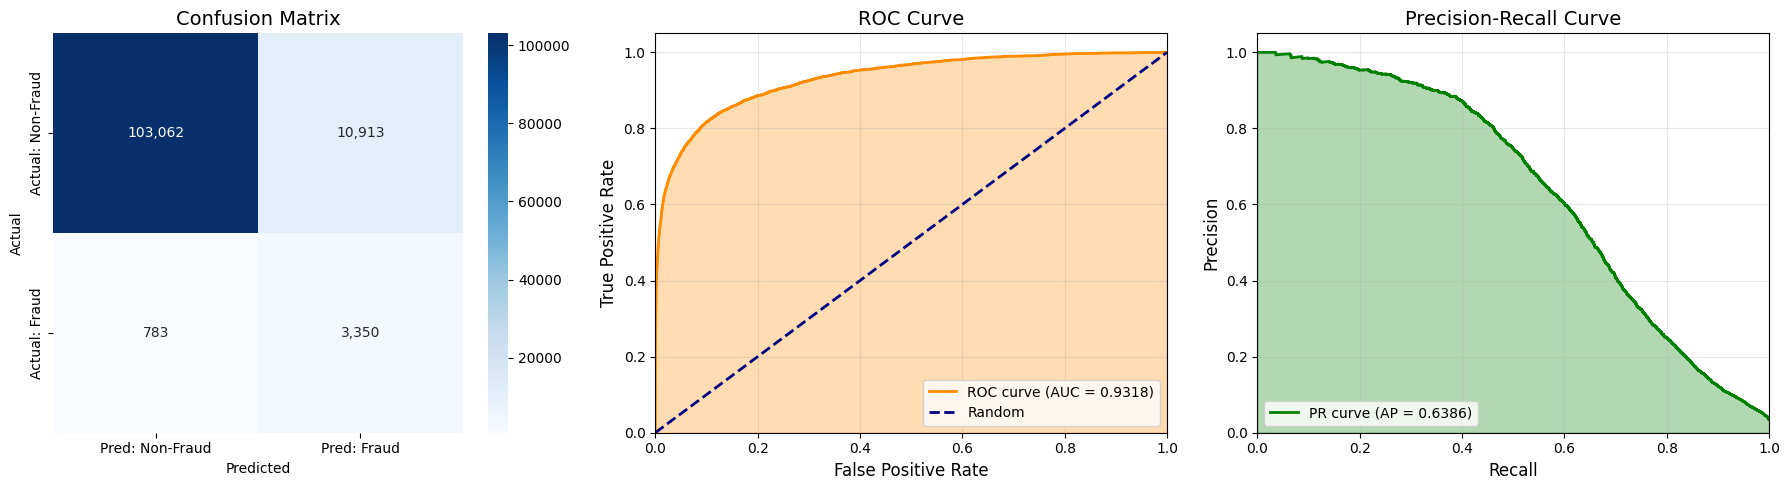

In [18]:
# ====================================================
# 12 Visualization - ROC Curve & Confusion Matrix
# ====================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: Non-Fraud', 'Pred: Fraud'],
            yticklabels=['Actual: Non-Fraud', 'Actual: Fraud'])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_final)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14)
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_pred_final)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
axes[2].fill_between(recall, precision, alpha=0.3, color='green')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall', fontsize=12)
axes[2].set_ylabel('Precision', fontsize=12)
axes[2].set_title('Precision-Recall Curve', fontsize=14)
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

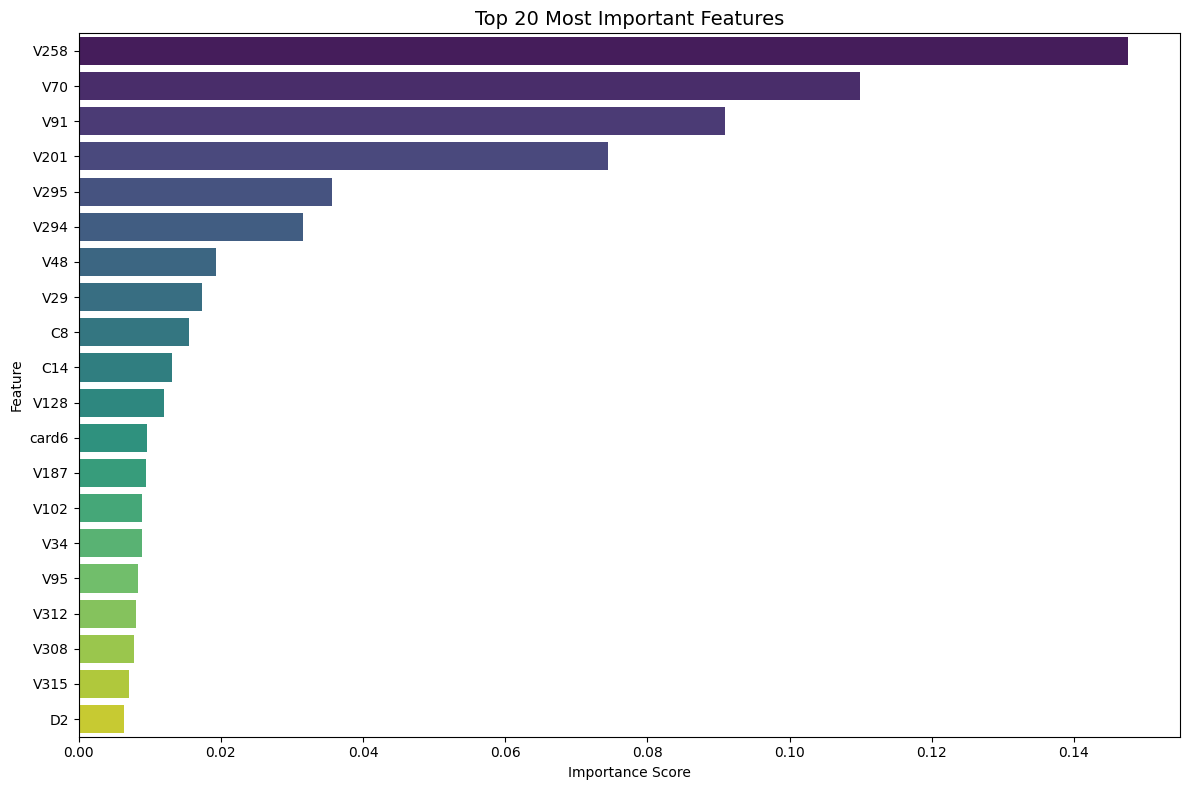


📋 Top 20 Most Important Features:
feature  importance
   V258    0.147561
    V70    0.109966
    V91    0.090931
   V201    0.074497
   V295    0.035693
   V294    0.031549
    V48    0.019301
    V29    0.017290
     C8    0.015479
    C14    0.013154
   V128    0.011974
  card6    0.009633
   V187    0.009521
   V102    0.008880
    V34    0.008862
    V95    0.008384
   V312    0.008087
   V308    0.007816
   V315    0.007073
     D2    0.006423


In [19]:
# ====================================================
# 13. Feature Importance
# ====================================================

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_n = 20
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance.head(top_n),
    palette='viridis'
)
plt.title(f'Top {top_n} Most Important Features', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n📋 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

In [20]:
# ====================================================
# STEP 14: Predict on Test Data & Create Submission
# ====================================================

print("="*50)
print("PREDICTING ON TEST DATA")
print("="*50)

# Predict probabilities on test data
test_predictions = final_model.predict_proba(X_test_final)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions
})

print(f"\nSubmission shape: {submission.shape}")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(submission['isFraud'].describe())

# Save submission
submission.to_csv('./submission_xgboost_KUDA.csv', index=False)
print("\n✅ Submission saved to 'submission_xgboost.csv'")

PREDICTING ON TEST DATA

Submission shape: (506691, 2)

Submission preview:
   TransactionID   isFraud
0        3663549  0.081914
1        3663550  0.083060
2        3663551  0.121987
3        3663552  0.058635
4        3663553  0.117362
5        3663554  0.153358
6        3663555  0.403671
7        3663556  0.538415
8        3663557  0.021755
9        3663558  0.224136

Prediction statistics:
count    506691.000000
mean          0.227895
std           0.214344
min           0.000763
25%           0.077463
50%           0.156958
75%           0.293388
max           0.999578
Name: isFraud, dtype: float64

✅ Submission saved to 'submission_xgboost.csv'


In [21]:
# ====================================================
# STEP 15: Model Summary
# ====================================================

print("="*60)
print("📊 FINAL MODEL SUMMARY")
print("="*60)
print(f"""
Dataset Information:
--------------------
• Training samples: {len(X_train):,}
• Validation samples: {len(X_val):,}
• Test samples: {len(X_test_final):,}
• Number of features: {X_train.shape[1]}

Class Distribution (Training):
------------------------------
• Non-Fraud: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)
• Fraud: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)

Best Hyperparameters:
--------------------""")
for param, value in rand_search.best_params_.items():
    print(f"• {param}: {value}")
    
print(f"""
Performance Metrics:
--------------------
• ROC-AUC (Baseline): {baseline_auc:.4f}
• ROC-AUC (Final): {final_auc:.4f}
• PR-AUC: {ap_score:.4f}
• Precision (Fraud): {tp/(tp+fp):.4f}
• Recall (Fraud): {tp/(tp+fn):.4f}
• F1-Score (Fraud): {2*tp/(2*tp+fp+fn):.4f}

Output Files:
-------------
• submission_xgboost_KUDA.csv - Test predictions
""")
print("="*60)

📊 FINAL MODEL SUMMARY

Dataset Information:
--------------------
• Training samples: 472,432
• Validation samples: 118,108
• Test samples: 506,691
• Number of features: 390

Class Distribution (Training):
------------------------------
• Non-Fraud: 455,902 (96.50%)
• Fraud: 16,530 (3.50%)

Best Hyperparameters:
--------------------
• n_estimators: 150
• min_child_weight: 3
• max_depth: 6
• learning_rate: 0.1

Performance Metrics:
--------------------
• ROC-AUC (Baseline): 0.9366
• ROC-AUC (Final): 0.9318
• PR-AUC: 0.6386
• Precision (Fraud): 0.2349
• Recall (Fraud): 0.8105
• F1-Score (Fraud): 0.3642

Output Files:
-------------
• submission_xgboost_KUDA.csv - Test predictions

